# Optimisation Project

- Karthick Ramasubramanian _(kr33733)_
- Raymond Li _(rll2497)_
- Rohitashwa Chakraborty _(rc47878)_
- Soumya Nayak _(sn25829)_

In [1]:
import numpy as np
import gurobi as gb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from numpy.random import normal, randint

GUROBI_TIMEOUT = 5 # in second

%matplotlib inline


In [2]:
cost = 0.5
g = 0.75

price = 1.00
t = 0.15

In [3]:
demand = pd.read_csv('price_demand_data.csv')

num_days = demand.shape[0]
demand.head()

,price,demand
0,1.05,283
1,0.86,771
2,1.21,185
3,0.94,531
4,0.76,1002


# Helper Functions

In [4]:
# Helper Functions

class Gurobi_Model():
    '''
        Class Method I made to help me encapsulate the whole Gurobi model creation, 
        Finding Slack Variable and perform sensitivity analysis
    '''
    
    def __init__(self, obj_linear, cons, sense, b, variable_types = 'C',
                lower_bound = None, upper_bound = None,
                optimisation_type = gb.GRB.MAXIMIZE, obj_quadratic = None) -> None:
        '''
            Initialising the Model
        '''
        if (obj_quadratic is None) and (obj_linear is None):
            raise Exception("No objective defined")

        constraints, variables = cons.shape

        ## Optimisation Model at work (Maximise)
        try:
            self.model = gb.Model()
            self.model_X = self.model.addMVar(variables,
                                        vtype=variable_types,
                                        lb= lower_bound, ub= upper_bound)

            self.model_constraints = self.model.addMConstr(cons, self.model_X, sense, b)
            self.model.setMObjective(obj_quadratic, obj_linear, 0, sense=optimisation_type)
            self.model.Params.OutputFlag = 0
            self.model.Params.TimeLimit = GUROBI_TIMEOUT

            self.model.optimize()

        except Exception:
            print("Error in optimising")
            raise Exception
        
        ## Assigning stuff for other use cases
        try:
            self.obj_q = obj_quadratic
            self.obj = obj_linear
            self.constraint = cons
            self.sense = sense
            self.b = b
        except Exception:
            print("Error in Storing equations")
            raise Exception
        return

    @property
    def optimal_obj(self): return self.model.objVal

    @property
    def optimal_x(self): return self.model_X.x

    @property
    def output(self):
        return {'objVal': self.optimal_obj,
                'x': self.optimal_x}

# Part - 1

In [5]:
from patsy import dmatrices
import statsmodels.api as sm

In [6]:
y, X = dmatrices('demand ~ price', data=demand)#, return_type='dataframe')
ols_model = sm.OLS(y, X)       # Set up the model
ols_model = ols_model.fit()       # Fit model (find the intercept and slopes)
print(f'R2: {ols_model.rsquared_adj}')
print(X.shape)
residual = y.flatten() - ols_model.predict(X)
residual

ols_model.summary()

R2: 0.6175700655080063
(99, 2)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 demand   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     159.3
Date:                Fri, 25 Feb 2022   Prob (F-statistic):           3.51e-22
Time:                        13:24:14   Log-Likelihood:                -636.17
No. Observations:                  99   AIC:                             1276.
Df Residuals:                      97   BIC:                             1282.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1924.7175    111.334     17.288      0.000    1703.750    2145.685
price      -1367.7125    108.379    -12.620      0.000   -1582.816   -1152.609
==============================================================================
Omnibus:                        0.906   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.636   Jarque-Bera (JB):                0.871
Skew:                          -0.222   Prob(JB):                        0.647
Kurtosis:                       2.881   Cond. No.                         14.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

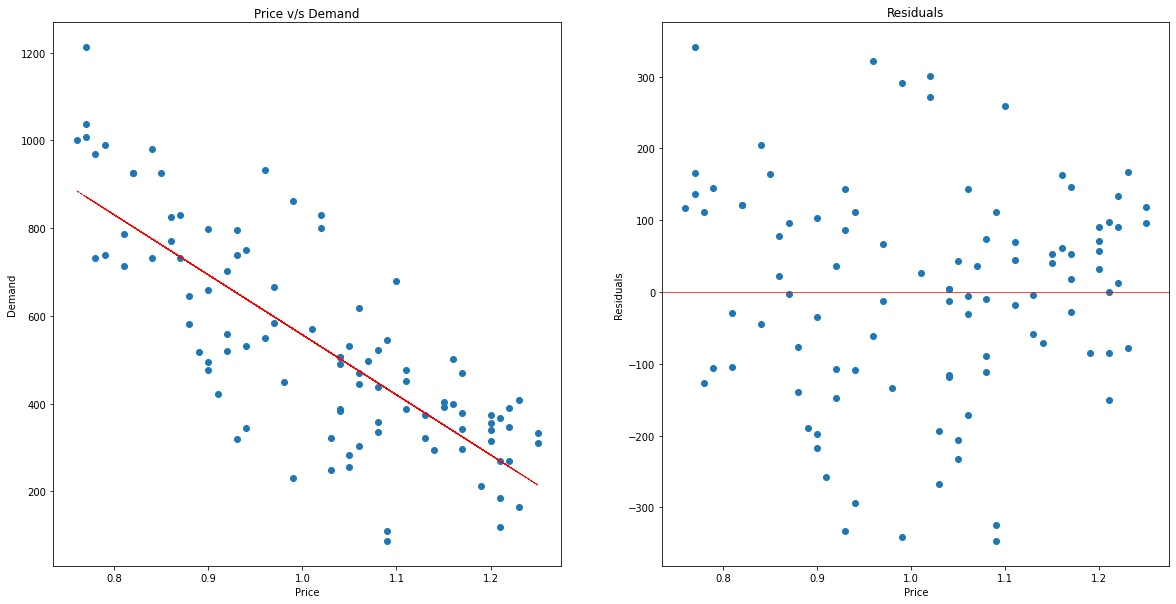

In [8]:
fig, ax = plt.subplots(1,2, sharex= True, sharey=False)
fig.set_size_inches(20, 10,  forward=True)

ax[0].scatter(x= X[:,1], y= y)

ax[0].plot(X[:,1],X@ols_model.params, color = "red", linestyle = "dashed", linewidth = 0.7)
ax[0].set_xlabel("Price")
ax[0].set_ylabel("Demand")
ax[0].set_title("Price v/s Demand");

ax[1].scatter(x= X[:,1], y= residual)

ax[1].axhline(y=0, color='r', linewidth = 0.7)
ax[1].set_xlabel("Price")
ax[1].set_ylabel("Residuals")
ax[1].set_title("Residuals");

# Part - 2

Assume price = 1, c=0.5, g=0.75, and t=0.15

Use residuals to generate demand data

In [9]:
predicted_demand = ols_model.predict(np.ones(X.shape))
predicted_demand += residual
predicted_demand[:20]

array([351.38562621, 579.52024662, 472.21963007, 448.93724855,
       673.7489942 , 453.13462041, 430.10324468, 480.8744971 ,
       554.19737186, 720.84312138, 449.58299807, 262.93724855,
       617.83400387, 653.19737186, 569.89675532, 623.96862428,
       224.26012331, 385.06275145, 544.70850097, 690.89675532])

# Part - 3

$$\max_{q} \text{ Profit}_i = \frac{1}{N}\sum_{i=1}^{N} {(pD_i - qc - g(D_i - q)^+ - t(q - D_i)^+)}$$

where:
- $(x)^+ = \max (x,0)$
- $D_i$ is the demand on Day _i_
- $q$ is the **Quantity** produced initially
- $p$ is the **Price** (Sale Price)
- $c$ is the **Cost** of production (Cost Price)
- $g$ is the **Expedited Cost** of production
- $t$ is the **Disposal** Cost

Thus the NLP can be reformulated as an LP in the following way:

$$\max_{q,h_1, h_2, ..., h_N} \text{ Profit}_i = \frac{1}{N}\sum_{i=1}^{N} {h_i}$$
subject to:
$$
h < {(pD_i - cq - g(D_i - q))} \\
h < {(pD_i - cq - t(q - D_i))} \\
h > -\infty \\
q > 0
$$

upon rewriting, we get:

$$\max_{q,h_1, h_2, ..., h_N} \text{ Profit}_i = \frac{1}{N}\sum_{i=1}^{N} {h_i}$$
subject to:
$$
h + (c-g)q < (p-g)D_i \\
h + (c+t)q < (p+t)D_i \\
h > -\infty \\
q > 0
$$



<!--Here Quantity, Cost and sale price are all vectors $\epsilon\text{  } \R^{5x1}$-->

In [10]:
# decision variables are (q, h1, h2, ..., h_num_days)
obj = np.zeros(num_days+1)
obj[1:] = 1.0/num_days

lb = np.zeros(num_days+1)
lb[1:] = -np.inf # quantity printed needs to be non-negative, but profit on a given day could possibly be negative

rhs = np.zeros(2*num_days)

direction = np.array(['<']*(2*num_days))

var_type = np.array(['I']+['C']*num_days)

In [11]:
A = np.zeros((2*num_days,num_days+1))

for r in range(num_days):
    A[2*r ,[0,r+1]] = [cost - g,1] # location 0 is q, location r+1 is this h
    rhs[2*r] = (price - g)*predicted_demand[r]

    A[2*r+1 ,[0,r+1]] = [cost + t,1]
    rhs[2*r+1] = (price + t)*predicted_demand[r]
# A.shape

In [12]:
part1_mod = Gurobi_Model(obj_linear= obj, 
                        cons= A, 
                        sense= direction, 
                        b= rhs,
                        lower_bound= lb,
                        variable_types= var_type
                    )
part1_mod.output

Set parameter Username
Academic license - for non-commercial use only - expires 2022-08-25


{'objVal': 231.4830547361909,
 'x': array([472.        ,  97.29347014, 262.88006165, 236.05490752,
        209.47783583, 286.43724855, 214.30481347, 187.81873139,
        238.21862428, 256.54934296, 298.21078034, 210.22044778,
         -4.42216417, 272.45850097, 281.29934296, 260.47418883,
        273.99215607, -48.9008582 , 136.02216417, 254.17712524,
        290.72418883, 266.39574952, 276.63006165, 248.5571869 ,
        293.87778228, 235.84518653, 298.60652986, -58.02869403,
         38.09175375, 325.08856262, 291.35652986,  26.73608208,
         83.31305972, 281.23203276, 275.85425048, 330.08071869,
        283.0571869 , 278.81503083, 287.70293641, 267.28921966,
        164.22044778, 279.97418883, 297.95850097, 254.85425048,
        249.7836551 , 239.36993835, 265.13562621, 241.82287476,
        270.62778228, 263.91928131, 252.86209441, 293.01568786,
        257.30490752, 293.06503083, 279.88562621, 205.42955222,
        258.17712524, -38.74175375, 230.72955222, 298.89347014,
     

In [13]:
print(f'The optimal quantity to order is {part1_mod.optimal_x[0]} which results in an expected profit of ${np.round(part1_mod.optimal_obj, 2)} per day')


The optimal quantity to order is 472.0 which results in an expected profit of $231.48 per day


# Part - 4

$$\max_{q} \text{ Profit}_i = \frac{1}{N}\sum_{i=1}^{N} {(pD_i - qc - g(D_i - q)^+ - t(q - D_i)^+)}$$

where:
- $(x)^+ = \max (x,0)$
- $D_i$ is the demand on Day _i_
- $q$ is the **Quantity** produced initially
- $p$ is the **Price** (Sale Price)
- $c$ is the **Cost** of production (Cost Price)
- $g$ is the **Expedited Cost** of production
- $t$ is the **Disposal** Cost

Given: $D_i = \beta_0 +\beta_1p + \epsilon_i$

Therefore, the Equation $pD_i - qc - g(D_i - q)^+ - t(q - D_i)^+$ can be rewritten as:

$$
p(\beta_0 +\beta_1p + \epsilon_i) - qc - g((\beta_0 +\beta_1p + \epsilon_i) - q)^+ - t(q - (\beta_0 +\beta_1p + \epsilon_i))^+ \\
\Rightarrow p(\beta_0 + \epsilon_i) - [qc + g((\beta_0 +\beta_1p + \epsilon_i) - q)^+ + t(q - (\beta_0 +\beta_1p + \epsilon_i))^+]  + (p\beta_1p)\\
\Rightarrow p(\beta_0 + \epsilon_i) - h_i  + (p\beta_1p)
$$

where 
$$
h_i = qc + g((\beta_0 +\beta_1p + \epsilon_i) - q)^+ + t(q - (\beta_0 +\beta_1p + \epsilon_i))^+
$$

upon rewriting, we get:


$$\max_{q, p,h_1, h_2, ..., h_N} \text{ Profit}_i = \frac{1}{N}\sum_{i=1}^{N} {p(\beta_0 + \epsilon_i) - h_i + (p\beta_1p)}$$
subject to:
$$
h_i + (g-c)q - p\beta_1g > g(\beta_0 + \epsilon_i)\\
h_i - (t+c)q + p\beta_1t > -t(\beta_0 + \epsilon_i)\\
h > -\infty \\
q > 0
$$

In [14]:
beta_0, beta_1 = ols_model.params

# decision variables are (p, q, h1, h2, ..., h_num_days)
# Linear Optimisation
obj = np.zeros(num_days+2)
obj[0] = beta_0 + residual.mean()
obj[2:] = -1.0/num_days

# Quadratic Optimisation
Q_obj = np.zeros((num_days+2, num_days+2))
Q_obj[0, 0] = beta_1

lb = np.zeros(num_days+2) # price, quantity can not be -ve
lb[2:] = -np.inf # quantity, price needs to be non-negative, but profit on a given day could possibly be negative

rhs = np.zeros(2*num_days)

direction = np.array(['>']*(2*num_days))

var_type = np.array(['C','I']+['C']*num_days)

In [15]:
A = np.zeros((2*num_days,num_days+2))

for r in range(num_days):
    A[2*r ,[0, 1,r+2]] = [-beta_1*g, g-cost, 1] # location 0 is p, loc 1 is q location r+2 is this h
    rhs[2*r] = g*(beta_0 + residual[r])

    A[2*r+1 ,[0, 1, r+2]] = [beta_1*t, -(cost + t), 1]
    rhs[2*r+1] = -t*(beta_0 + residual[r])
# A.shape

In [16]:
quad_mod = Gurobi_Model(obj_linear= obj,
                        obj_quadratic= Q_obj,
                        cons= A, 
                        sense= direction, 
                        b= rhs,
                        lower_bound= lb,
                        variable_types= var_type
                    )
quad_mod.output

{'objVal': 234.42487299858658,
 'x': array([  0.95383926, 535.        , 285.57196301, 348.24115027,
        267.76568786, 270.93921966, 418.91271096, 270.30961388,
        273.76432024, 274.25683813, 329.2489942 , 454.23330634,
        270.84235723, 298.83921966, 376.97646821, 403.4989942 ,
        341.02353179, 381.57743351, 304.64078844, 280.52039422,
        322.13234103, 431.77353179, 358.78821386, 389.49115027,
        305.27252599, 441.23431214, 267.5       , 455.42055489,
        305.83137572, 293.29392601, 534.86665317, 433.67055489,
        294.77510058, 287.3954948 , 403.29706359, 387.16371676,
        549.84312138, 408.77252599, 396.04605779, 422.70977454,
        361.46862428, 276.84235723, 399.52353179, 453.47646821,
        324.16371676, 308.95193061, 277.71078034, 355.00784393,
        285.06958958, 371.48431214, 351.35880924, 318.18724855,
        438.64802889, 331.51568786, 438.79605779, 399.25784393,
        271.46725665, 334.13234103, 303.31568786, 268.16725665,
    

In [17]:
print(f'The optimal quantity to print initially is {int(quad_mod.optimal_x[1])}, and sell them at a price of ${np.round(quad_mod.optimal_x[0],2)} which results in an expected profit of ${np.round(quad_mod.optimal_obj, 2)} per day')

The optimal quantity to print initially is 535, and sell them at a price of $0.95 which results in an expected profit of $234.42 per day


# Part - 6

In [18]:
def simulation(dataset: pd.DataFrame)->dict:

    # ----- OLS ----
    y, X = dmatrices('demand ~ price', data=dataset)#, return_type='dataframe')
    ols_model = sm.OLS(y, X)       # Set up the model
    ols_model = ols_model.fit()       # Fit model (find the intercept and slopes)
    # print(f'R2: {ols_model.rsquared_adj}')
    # print(X.shape)
    residual = y.flatten() - ols_model.predict(X)
    residual

    beta_0, beta_1 = ols_model.params

    # ---- QP Optimization ----
    # decision variables are (p, q, h1, h2, ..., h_num_days)
    # Linear Optimisation
    obj = np.zeros(num_days+2)
    obj[0] = beta_0 + residual.mean()
    obj[2:] = -1.0/num_days

    # Quadratic Optimisation
    Q_obj = np.zeros((num_days+2, num_days+2))
    Q_obj[0, 0] = beta_1

    lb = np.zeros(num_days+2) # price, quantity can not be -ve
    lb[2:] = -np.inf # quantity, price needs to be non-negative, but profit on a given day could possibly be negative

    rhs = np.zeros(2*num_days)

    direction = np.array(['>']*(2*num_days))

    var_type = np.array(['C','I']+['C']*num_days)

    A = np.zeros((2*num_days,num_days+2))

    for r in range(num_days):
        A[2*r ,[0, 1,r+2]] = [-beta_1*g, g-cost, 1] # location 0 is p, loc 1 is q location r+2 is this h
        rhs[2*r] = g*(beta_0 + residual[r])

        A[2*r+1 ,[0, 1, r+2]] = [beta_1*t, -(cost + t), 1]
        rhs[2*r+1] = -t*(beta_0 + residual[r])
    
    sim_mod = Gurobi_Model(obj_linear= obj,
                        obj_quadratic= Q_obj,
                        cons= A, 
                        sense= direction, 
                        b= rhs,
                        lower_bound= lb,
                        variable_types= var_type
                    )
    return {
            'profit': sim_mod.optimal_obj,
            'price': sim_mod.optimal_x[0],
            'quantity': int(sim_mod.optimal_x[1])
        }

In [19]:
def bootstrap():
    index = np.random.randint(size= demand.shape[0], low= 0, high= demand.shape[0])
    bootstraped_sample = demand.iloc[index].reset_index(drop= True)

    return simulation(bootstraped_sample)


In [20]:
bootstrap_response = bootstrap()
print(f'''Stats of the bootstraped sample:
        Expected Profits: ${np.round(bootstrap_response['profit'], 2)}
        Optimal Price: ${np.round(bootstrap_response['price'], 2)}
        Optimal Quantity: {bootstrap_response['quantity']}
        ''')

Stats of the bootstraped sample:
        Expected Profits: $244.52
        Optimal Price: $0.95
        Optimal Quantity: 571
        


# Part - 7

In [21]:
nsim = 10000

optimal_price = []
optimal_quantity = []
expected_profit = []

for sim in tqdm(range(nsim)):
    bs_result = bootstrap()
    optimal_price.append(bs_result['price'])
    optimal_quantity.append(bs_result['quantity'])
    expected_profit.append(bs_result['profit'])

100%|██████████| 10000/10000 [01:19<00:00, 125.75it/s]


### Price vs Quantity

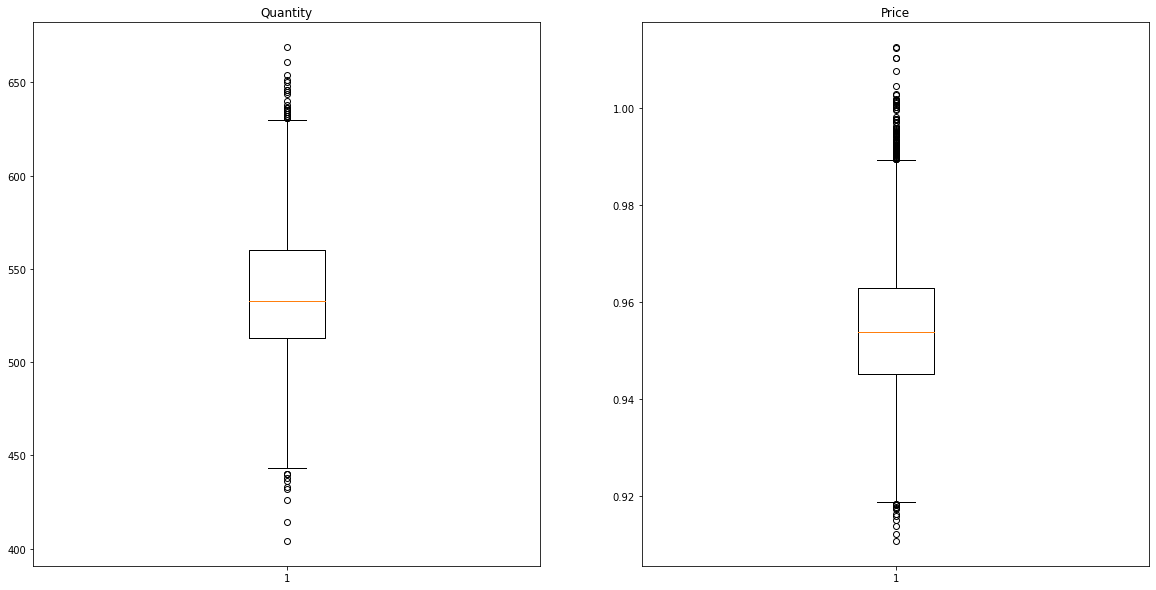

In [22]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(20, 10,  forward=True)

ax[0].boxplot(optimal_quantity)
ax[0].set_title("Quantity");

ax[1].boxplot(optimal_price)
ax[1].set_title("Price");

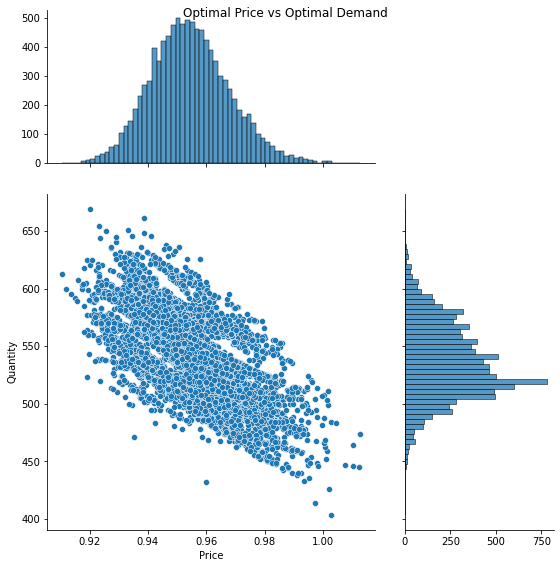


Expected Optimal Price: $0.95 (± $0.03) [95% ConI]
Expected Optimal Quantity: 536 (± 64.08) [95% ConI]



In [23]:
out = pd.DataFrame({'Price' : optimal_price, 'Quantity' : optimal_quantity, 'Profit' : expected_profit})

sns.jointplot(data = out, x = 'Price', y = 'Quantity', height = 8, ratio = 2, marginal_ticks = True)

plt.suptitle('Optimal Price vs Optimal Demand \n')
plt.show()
print(f'''
Expected Optimal Price: ${np.round(np.mean(optimal_price),2)} (± ${np.round(1.96*np.std(optimal_price),2)}) [95% ConI]
Expected Optimal Quantity: {int(np.mean(optimal_quantity))} (± {np.round(1.96 * np.std(optimal_quantity),2)}) [95% ConI]
''')

### Profit

Text(0, 0.5, 'Probability')

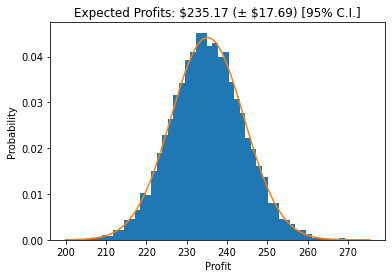

In [24]:
import numpy as np
import scipy.stats as stats
import math

mu, sigma = stats.norm.fit(expected_profit)

plt.hist(expected_profit, bins= 50, density= True);

x = np.linspace(plt.xlim()[0], plt.xlim()[1], 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.title(f'Expected Profits: \${np.round(np.mean(expected_profit),2)} (± \${np.round(1.96*np.std(expected_profit),2)}) [95% C.I.]')
plt.xlabel('Profit')
plt.ylabel('Probability')

***
***